# Structure retrieval

This notebook explores mapping to other latent spaces to do better retrieval

### 1. Environment setup

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import clip
import torch.nn as nn
import h5py
import umap
from tqdm import tqdm

# custom functions #
import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_type = torch.float16
torch.cuda.empty_cache()

In [2]:
subj = 1
data_path = "/weka/proj-fmri/shared/mindeyev2_dataset"
imagery_path = "/weka/proj-fmri/shared/nsd_imagery/data"

In [3]:
vox_imagery, image_imagery = utils.load_nsd_mental_imagery(
    subject=subj, mode="imagery", stimtype="all", 
    average=True, nest=False, data_root=imagery_path)

torch.Size([18, 1, 15724]) torch.Size([18, 3, 425, 425])


### 2. Draw images

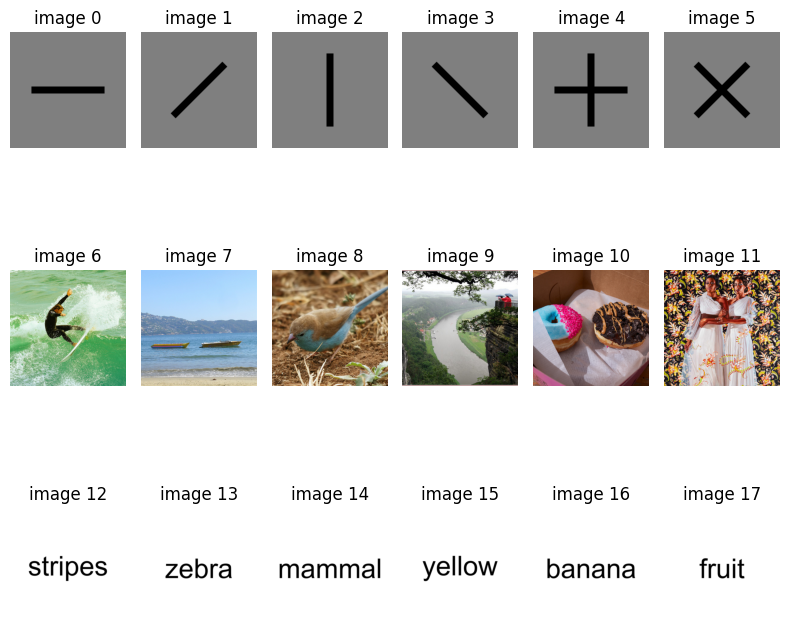

In [10]:
# Draw the images
fig, axs = plt.subplots(3, 6, figsize=(8, 8))
for row in range(3):
    for col in range(6):
        idx = row*6 + col
        image = utils.torch_to_Image(image_imagery[idx])
        axs[row, col].imshow(image)
        axs[row, col].set_title(f"image {idx}")
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

### 3. Visualize CLIP space

In [4]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
nsd_images = f['images'][:] # if you go OOM you can remove the [:] so it isnt preloaded to cpu! (will require a few edits elsewhere tho)
nsd_images = torch.Tensor(nsd_images).to("cpu")
print("Loaded all 73k possible NSD images to cpu!", nsd_images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [5]:
# Pass images through VAE encoder and plot latent space in tSNE
# Compute latents for 73k + 18 images, then plot for only 18 images

# Define embedder
clip_model, preprocess = clip.load("ViT-L/14", device=device)

def process_batches(images, batch_size=1000):
    embeddings = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    for i in range(num_batches):
        batch = images[i * batch_size: (i + 1) * batch_size].to(device)
        preproc_img = preprocess(batch)
        with torch.no_grad():
            emb = clip_model.encode_image(preproc_img)
            # Fix clip encoder for text (we encode text with text rather than image encoder)
            # TODO: Try with last hidden layer of ViT-L, SDXL unclip hidden.
            # TODO: visualize decoded clip vectors?
        embeddings.append(emb.cpu())
    return torch.cat(embeddings, dim=0)

# Embed NSD images
nsd_images = nsd_images.to(data_type).to(device)
nsd_emb = process_batches(nsd_images)
print(nsd_emb.shape)

# Embed imagined images
image_imagery = image_imagery.to(device)
imagine_emb = process_batches(image_imagery)
print(imagine_emb.shape)

torch.Size([73000, 768])
torch.Size([18, 768])


/admin/home-jonxu/mambaforge/envs/imagery/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
# Concatenate the two tensors
combined_emb = torch.cat((nsd_emb, imagine_emb), dim=0)
print(combined_emb.shape)

# Apply UMAP to reduce to 2D
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding = umap_reducer.fit_transform(combined_emb)

# Separate the 2D embeddings
embedding_73k = embedding[:73000]
embedding_18 = embedding[73000:]


torch.Size([73018, 768])


NameError: name 'embedding_70k' is not defined

<Figure size 1000x800 with 0 Axes>

In [31]:
embedding_18[:6]

array([[ 2.3837328, -4.6408234],
       [ 2.3829348, -4.6420527],
       [ 2.3824344, -4.642194 ],
       [ 2.3800504, -4.6447215],
       [ 2.384535 , -4.6409497],
       [ 2.3824027, -4.6430616]], dtype=float32)

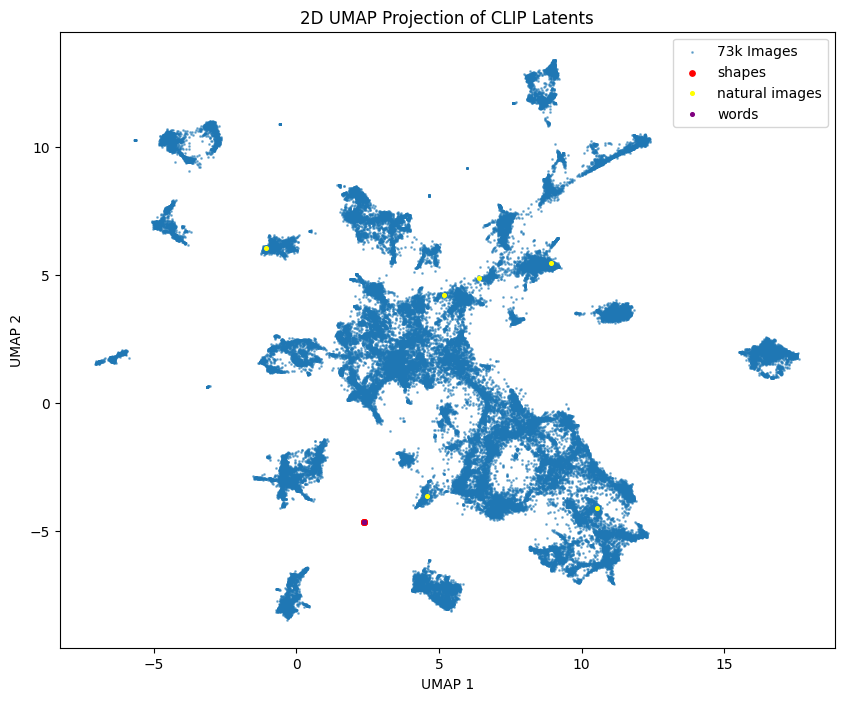

In [40]:
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Convert the 18 images to PIL format and store them in a list
image_list = [Image.fromarray((img.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')) for img in image_imagery]

# Plotting the 18 latents
plt.figure(figsize=(10, 8))
plt.scatter(embedding_73k[:, 0], embedding_73k[:, 1], s=1, alpha=0.5, label='73k Images')
plt.scatter(embedding_18[:6, 0], embedding_18[:6, 1], s=15, color='red', label='shapes')
plt.scatter(embedding_18[6:12, 0], embedding_18[6:12, 1], s=7, color='yellow', label='natural images')
plt.scatter(embedding_18[12:, 0], embedding_18[12:, 1], s=7, color='purple', label='words')


# Add the 18 images to the plot
# for i, (xy, img) in enumerate(zip(embedding_18, image_list)):
#     imagebox = OffsetImage(img, zoom=0.05)  # Adjust zoom to fit the images well
#     ab = AnnotationBbox(imagebox, xy, frameon=False)
#     plt.gca().add_artist(ab)

plt.legend()
plt.title("2D UMAP Projection of CLIP Latents")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.savefig("clip_umap.png", format="png", dpi=300)
plt.show()

### Visualize VAE space

In [5]:
from diffusers import AutoencoderKL  
cache_dir="/weka/proj-fmri/shared/cache"

# Define VAE
autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256,
)
ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')
autoenc.load_state_dict(ckpt)

autoenc.eval()
autoenc.requires_grad_(False)
autoenc.to(device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

def process_batches(images, batch_size=1000):
    latents = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    for i in tqdm(range(num_batches)):
        batch = images[i * batch_size: (i + 1) * batch_size].to(device)
        preproc_img = preprocess(batch)
        with torch.no_grad():
            image_enc = autoenc.encode(2*preproc_img-1).latent_dist.mode() * 0.18215
        latents.append(image_enc.cpu())
    return torch.cat(latents, dim=0)

# Embed NSD images
nsd_images = nsd_images.to(device)
print("Processing nsd images")
nsd_latents = process_batches(nsd_images)
print(nsd_latents.shape)

# Embed imagined images
image_imagery = image_imagery.to(device)
print("Processing imagine images")
imagine_latents = process_batches(image_imagery)
print(imagine_latents.shape)

Processing nsd images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [02:07<00:00,  5.74it/s]


torch.Size([73000, 4, 28, 28])
Processing imagine images


  0%|                                                                                                             | 0/1 [00:00<?, ?it/s]/admin/home-jonxu/mambaforge/envs/imagery/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00

torch.Size([18, 4, 28, 28])


In [7]:
# Concatenate the two tensors
combined_latents = torch.cat((nsd_latents, imagine_latents), dim=0)
print(combined_latents.shape)
flattened_combined_latents = combined_latents.view(combined_latents.size(0), -1)
print(flattened_combined_latents.shape)

# Apply UMAP to reduce to 2D
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding = umap_reducer.fit_transform(flattened_combined_latents)

# Separate the 2D embeddings
embedding_73k = embedding[:73000]
embedding_18 = embedding[73000:]

torch.Size([73018, 4, 28, 28])
torch.Size([73018, 3136])


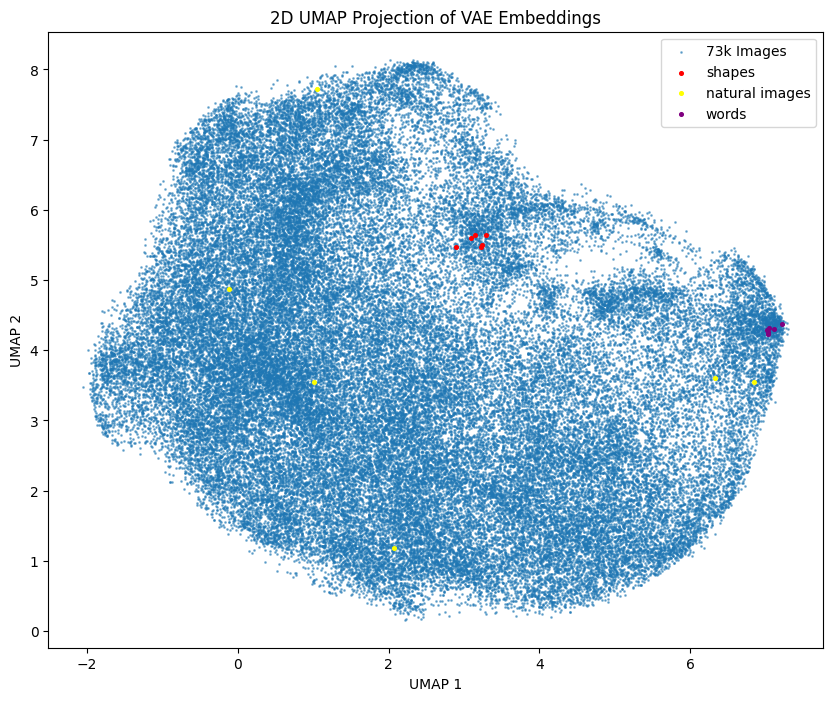

In [10]:
from PIL import Image

# Convert the 18 images to PIL format and store them in a list
image_list = [Image.fromarray((img.cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')) for img in image_imagery]

# Plotting the 18 latents
plt.figure(figsize=(10, 8))
plt.scatter(embedding_73k[:, 0], embedding_73k[:, 1], s=1, alpha=0.5, label='73k Images')
plt.scatter(embedding_18[:6, 0], embedding_18[:6, 1], s=7, color='red', label='shapes')
plt.scatter(embedding_18[6:12, 0], embedding_18[6:12, 1], s=7, color='yellow', label='natural images')
plt.scatter(embedding_18[12:, 0], embedding_18[12:, 1], s=7, color='purple', label='words')

plt.legend()
plt.title("2D UMAP Projection of VAE Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

plt.savefig("vae_umap.png", format="png", dpi=300)
plt.show()